# Proyecto de Deep Learning - Clasificación de Imágenes con Transfer Learning
## Universidad Militar Nueva Granada - 2024

###Nombres: Daren Santiago Herrera - Daniela Fuentes Bello - Jose Luis Pineda

Este proyecto implementa un modelo de clasificación de imágenes utilizando tres arquitecturas preentrenadas: VGG16, ResNet50 e InceptionV3.
Fases:
1. Carga y distribución del dataset
2. Entrenamiento usando Transfer Learning
3. Fine-tuning
4. Evaluación del modelo



In [12]:
!pip install torch torchvision matplotlib


# Importación de Librerias

In [13]:
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from google.colab import drive


## Preparación del DataSet y Aumento de Datos

In [14]:

drive.mount('/content/drive')

# Ahora puedes acceder al archivo desde tu Drive y descomprimirlo
zip_path = '/content/drive/MyDrive/DataSet.zip'
extract_path = '/content/DataSet/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




*   Carga del dataset y preprocesamiento
*   Usamos torchvision para cargar los datos de entrenamiento y validación
*   Se dividen 70% para entrenamiento y 30% para validación






**ResNet50 y VGG16**: Estos modelos esperan imágenes de entrada de tamaño 224x224 píxeles. Por lo tanto, las imágenes de tu conjunto de datos se deben transformar o redimensionar a este tamaño antes de pasarlas a la red.


In [17]:
# Define transformaciones y carga del dataset
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Para VGG16 y ResNet50
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(extract_path, transform=data_transforms)

# Definir el tamaño de cada subconjunto (70% entrenamiento, 30% validación)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# Verificar las clases y etiquetas
class_names = full_dataset.classes
print("Clases encontradas:", class_names)

# Número de clases
num_classes = 5  # Cambia esto al número de clases en tu dataset

# Ajustar los modelos
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(in_features=model_resnet50.fc.in_features, out_features=num_classes)

model_inception = models.inception_v3(weights='DEFAULT', aux_logits=True)  # Cambiado a True
model_inception.fc = nn.Linear(in_features=model_inception.fc.in_features, out_features=num_classes)

# Verificar el tipo de las etiquetas
for inputs, labels in dataloaders['train']:
    print(labels.dtype)  # Debe ser torch.int64 o torch.long
    break  # Rompe el bucle después de la primera iteración


Clases encontradas: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
torch.int64


**InceptionV3:** Este modelo fue diseñado para manejar imágenes de entrada de 299x299 píxeles. Esto significa que cualquier imagen que se quiera clasificar usando InceptionV3 debe ser redimensionada a 299x299 en lugar de 224x224.

In [18]:
# InceptionV3 requiere imágenes de tamaño 299x299
data_transforms_inception = transforms.Compose([
    transforms.Resize((299, 299)),  # Tamaño de entrada esperado para InceptionV3
    transforms.ToTensor()
])

# Cargar el dataset completo para InceptionV3
full_dataset_inception = datasets.ImageFolder(extract_path, transform=data_transforms_inception)

# Dividir el dataset completo en entrenamiento y validación (70% - 30%)
train_size_inception = int(0.7 * len(full_dataset_inception))
val_size_inception = len(full_dataset_inception) - train_size_inception

# Dividir el dataset completo en entrenamiento y validación
train_dataset_inception, val_dataset_inception = random_split(full_dataset_inception, [train_size_inception, val_size_inception])

# Crear DataLoaders para InceptionV3
train_loader_inception = DataLoader(train_dataset_inception, batch_size=32, shuffle=True)
val_loader_inception = DataLoader(val_dataset_inception, batch_size=32, shuffle=False)

# Definir los dataloaders y dataset_sizes para InceptionV3
dataloaders_inception = {
    'train': train_loader_inception,
    'val': val_loader_inception
}

dataset_sizes_inception = {
    'train': len(train_dataset_inception),
    'val': len(val_dataset_inception)
}



## Cargamos modelos preentrenados (VGG16, ResNet50, InceptionV3)

# Definición del Modelo VGG16

**En cada modelo entrenado, usamos Transfer Learning, donde congelamos las capas convolucionales y entrenamos solo las capas finales**

In [19]:
# Definir el dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda:0


In [20]:
model_vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')  # Cargar el modelo VGG16 preentrenado
for param in model_vgg16.features.parameters():
    param.requires_grad = False  # Congelar capas convolucionales

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, 5)  # Cambiar la capa fully connected para 5 clases
model_vgg16 = model_vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier[6].parameters(), lr=0.001)
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)


# Definición del Modelo ResNet50

In [21]:
model_resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # Cargar el modelo ResNet50 preentrenado
for param in model_resnet50.parameters():
    param.requires_grad = False  # Congelar todas las capas

num_ftrs_resnet = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs_resnet, 5)  # Modificar la última capa para 5 clases
model_resnet50 = model_resnet50.to(device)

optimizer_resnet50 = optim.Adam(model_resnet50.fc.parameters(), lr=0.001)
exp_lr_scheduler_resnet50 = lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)


# Definición del Modelo InceptionV3

In [22]:
model_inception = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')  # Cargar InceptionV3 preentrenado
for param in model_inception.parameters():
    param.requires_grad = False  # Congelar todas las capas

num_ftrs_inception = model_inception.fc.in_features
model_inception.fc = nn.Linear(num_ftrs_inception, 5)  # Cambiar la capa fully connected para 5 clases
model_inception = model_inception.to(device)

optimizer_inception = optim.Adam(model_inception.fc.parameters(), lr=0.001)
exp_lr_scheduler_inception = lr_scheduler.StepLR(optimizer_inception, step_size=7, gamma=0.1)


## Funcion de Entrenamiento



*   **Definimos el optimizador Adam con una tasa de aprendizaje de 0.001**, Esto es adecuado para el fine-tuning ya que queremos que el modelo aprenda sin cambios bruscos
*   **Congelamos todas las capas excepto las fully connected**,Esto permite que el modelo conserve las características aprendidas en otras tareas y se adapte a nuestro problema específico.



*      model: El modelo que se entrena.
*      criterion: La función de pérdida.
* optimizer: El algoritmo que actualiza los pesos del modelo.
*scheduler: Controla la tasa de aprendizaje.
*num_epochs: El número de épocas para entrenar el modelo.
*dataloaders: Los datos de entrenamiento y validación.
*dataset_sizes: Tamaños del dataset de entrenamiento y validación.

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, dataloaders=None, dataset_sizes=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modo de entrenamiento
            else:
                model.eval()   # Modo de validación

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Para InceptionV3, manejar la salida auxiliar solo en entrenamiento
                    if isinstance(model, models.Inception3) and phase == 'train':
                        # En entrenamiento, InceptionV3 devuelve dos salidas
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2  # Usamos la salida auxiliar con menor peso
                    else:
                        # En validación, solo hay una salida
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model



## Entrenar los Modelos

Se entrenan los 3 modelos cada uno en 10 epocas mosntrando el train loss , validation loss y acurracy en cada epoca.

In [24]:
# Entrenar VGG16 (224x224 imágenes)
model_vgg16 = train_model(model_vgg16, criterion, optimizer_vgg16, exp_lr_scheduler_vgg16, num_epochs=10, dataloaders=dataloaders, dataset_sizes=dataset_sizes)

# Entrenar ResNet50 (224x224 imágenes)
model_resnet50 = train_model(model_resnet50, criterion, optimizer_resnet50, exp_lr_scheduler_resnet50, num_epochs=10, dataloaders=dataloaders, dataset_sizes=dataset_sizes)

# Entrenar InceptionV3 (299x299 imágenes)
model_inception = train_model(model_inception, criterion, optimizer_inception, exp_lr_scheduler_inception, num_epochs=10, dataloaders=dataloaders_inception, dataset_sizes=dataset_sizes_inception)


Epoch 0/9
----------
train Loss: 0.7139 Acc: 0.7309
val Loss: 0.5487 Acc: 0.8038

Epoch 1/9
----------
train Loss: 0.5731 Acc: 0.7878
val Loss: 0.5375 Acc: 0.8000

Epoch 2/9
----------
train Loss: 0.5531 Acc: 0.8019
val Loss: 0.4914 Acc: 0.8196

Epoch 3/9
----------
train Loss: 0.5264 Acc: 0.8040
val Loss: 0.4886 Acc: 0.8278

Epoch 4/9
----------
train Loss: 0.5189 Acc: 0.8097
val Loss: 0.4899 Acc: 0.8299

Epoch 5/9
----------
train Loss: 0.5038 Acc: 0.8180
val Loss: 0.4777 Acc: 0.8299

Epoch 6/9
----------
train Loss: 0.4967 Acc: 0.8208
val Loss: 0.5220 Acc: 0.8168

Epoch 7/9
----------
train Loss: 0.4599 Acc: 0.8315
val Loss: 0.4634 Acc: 0.8395

Epoch 8/9
----------
train Loss: 0.4332 Acc: 0.8455
val Loss: 0.4612 Acc: 0.8392

Epoch 9/9
----------
train Loss: 0.4396 Acc: 0.8377
val Loss: 0.4632 Acc: 0.8371

Training complete in 11m 18s
Best val Acc: 0.8395
Epoch 0/9
----------
train Loss: 0.7301 Acc: 0.7946
val Loss: 0.4710 Acc: 0.8814

Epoch 1/9
----------
train Loss: 0.3899 Acc: 0.8

## Evaluación del Modelo con Métricas (Confusión, Precision, Recall, F1-score)
**Evaluamos el modelo usando accuracy, precision, recall, y F1-score**, Estas métricas nos permiten tener una mejor visión del rendimiento del modelo en un dataset desbalanceado

In [25]:
# Obtener los nombres de las clases (esto es importante para etiquetar la matriz de confusión)
class_names = full_dataset.classes


In [26]:
def evaluate_model(model, dataloader):
    model.eval()  # Cambiar el modelo al modo evaluación
    y_true = []
    y_pred = []

    # Desactivar gradientes para la evaluación
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Obtener los nombres de las clases
    class_names = full_dataset.classes

    # Generar el reporte de clasificación
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Etiquetas según tus clases
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular métricas adicionales
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Mostrar los resultados
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    return accuracy, f1, precision, recall



## Evaluar los Modelos

Evaluating VGG16
Classification Report:
              precision    recall  f1-score   support

       Apple       0.76      0.75      0.75       547
      Banana       0.89      0.87      0.88       620
       Grape       0.81      0.84      0.82       561
       Mango       0.85      0.82      0.83       605
  Strawberry       0.88      0.91      0.90       577

    accuracy                           0.84      2910
   macro avg       0.84      0.84      0.84      2910
weighted avg       0.84      0.84      0.84      2910



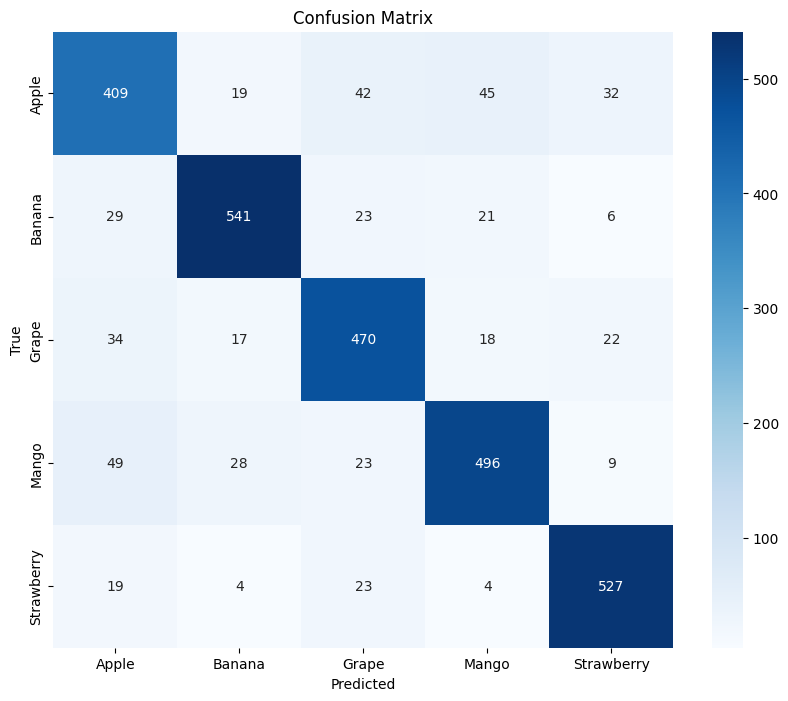

Accuracy: 0.8395
F1 Score (weighted): 0.8393
Precision (weighted): 0.8395
Recall (weighted): 0.8395
Evaluating ResNet50
Classification Report:
              precision    recall  f1-score   support

       Apple       0.87      0.86      0.86       547
      Banana       0.94      0.95      0.94       620
       Grape       0.91      0.92      0.91       561
       Mango       0.91      0.89      0.90       605
  Strawberry       0.95      0.97      0.96       577

    accuracy                           0.92      2910
   macro avg       0.92      0.92      0.92      2910
weighted avg       0.92      0.92      0.92      2910



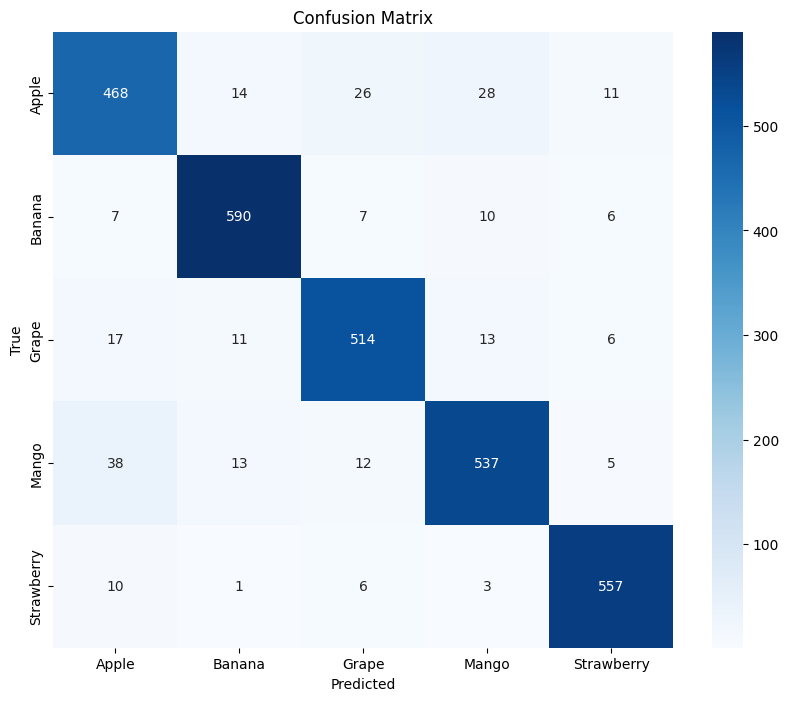

Accuracy: 0.9162
F1 Score (weighted): 0.9159
Precision (weighted): 0.9158
Recall (weighted): 0.9162
Evaluating InceptionV3
Classification Report:
              precision    recall  f1-score   support

       Apple       0.67      0.83      0.74       547
      Banana       0.89      0.88      0.88       620
       Grape       0.82      0.86      0.84       561
       Mango       0.89      0.67      0.76       605
  Strawberry       0.89      0.88      0.89       577

    accuracy                           0.82      2910
   macro avg       0.83      0.82      0.82      2910
weighted avg       0.83      0.82      0.82      2910



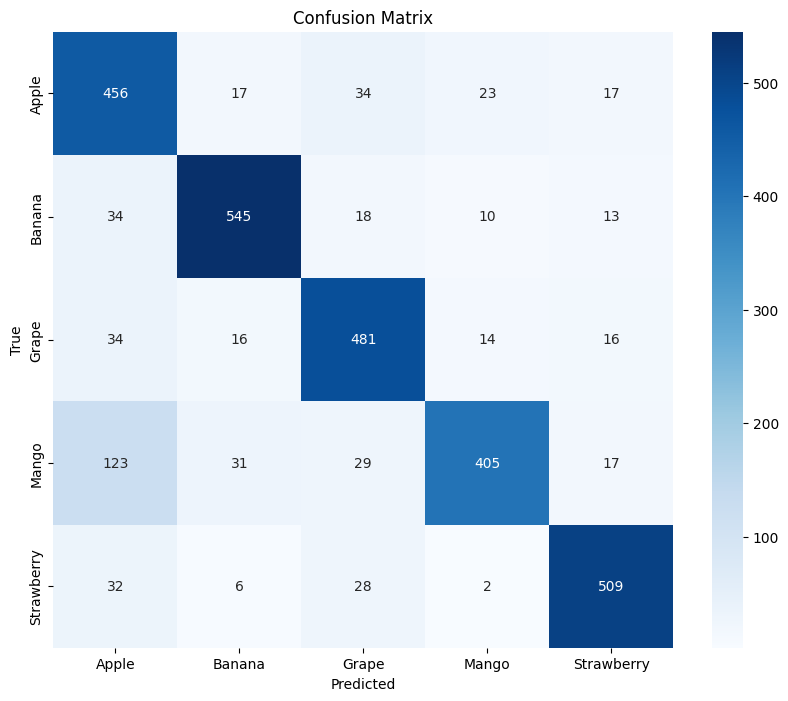

Accuracy: 0.8234
F1 Score (weighted): 0.8237
Precision (weighted): 0.8341
Recall (weighted): 0.8234


(0.8233676975945017,
 0.8236955490486875,
 0.8341211180469628,
 0.8233676975945017)

In [27]:
# Evaluar VGG16
print("Evaluating VGG16")
evaluate_model(model_vgg16, dataloaders['val'])

# Evaluar ResNet50
print("Evaluating ResNet50")
evaluate_model(model_resnet50, dataloaders['val'])

# Evaluar InceptionV3
print("Evaluating InceptionV3")
evaluate_model(model_inception, dataloaders['val'])
